
# Karate Club

Zachary's Karate Club graph

Data file from:
http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/UciData.htm

Zachary W. (1977).
An information flow model for conflict and fission in small groups.
Journal of Anthropological Research, 33, 452-473.


In [1]:
%matplotlib inline

import urllib.request
import io
import zipfile

from pathlib import Path
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

import igraph as ig

In [2]:
G = nx.karate_club_graph()
#print("Node Degree")
#for v in G:
#    print(f"{v:4} {G.degree(v):6}")
#print(G)

In [28]:
#print(list(G.nodes))
#print(list(G.edges))
#list(G.adj[1])  # or list(G.neighbors(1))
#G.degree[1]  # the number of edges incident to 1
#G[1]  # same as G.adj[1]
#nx.maximal_independent_set(G) 

In [29]:
#N = nx.neighbors(G,1)
#for i in N:
#    print(i)

In [30]:
#path = nx.single_source_dijkstra_path(G, 0)
#path[25]

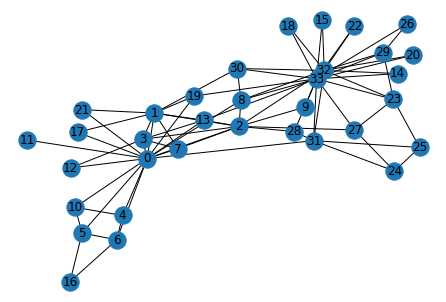

In [31]:
nx.draw(G, with_labels=True)
plt.show()

In [4]:
N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

dm = np.zeros((N,N), dtype=int)

p = nx.shortest_path(G)

for i in range(0,N):
    for j in range(0,N):
        dm[i][j] = len(p[i][j])-1

G.edges


EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)])

In [23]:
mip = 0

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=int)
ub = np.zeros((N), dtype=int)
time = np.zeros((N), dtype=int)
gap = np.zeros((N), dtype=int)
nodes = np.zeros((N), dtype=int)
status_ = np.zeros((N), dtype=int)

RESULT_PATH   = Path('../result/')

for i in G:

    model = gp.Model("tukey")

    if (mip == 1):
        x = model.addVars(N, vtype=GRB.BINARY, name="x")
    else:
        x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")
    
    obj = 0
    for j in G:
        obj += 1 * x[j]
         
    model.setObjective(obj, GRB.MINIMIZE)
    
    # configurando parametros
    # model.Params.TimeLimit = 60
    model.Params.MIPGap = 1.e-6
    model.Params.Threads = 1
    # model.Params.Presolve = 0
    # model.Params.Cuts = 0
 
    # Turn off display and heuristics
    gp.setParam('OutputFlag', 0)
    gp.setParam('Heuristics', 0)

    constr0 = 0
    constr0 += 1*x[i]
    model.addConstr(constr0 == 1)

    for u in range(0,N):
        for w in range(u+1,N):
            if dm[u,w] <= N:
                for s in range(0,N):
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            constr1 = x[u] + x[w]
                            model.addConstr(constr1 >= x[s])

    #x[i].Start = 1.0
    #relax = model.relax()    
    #relax.optimize()
    #model.write("tukey.lp")

    model.optimize()

    tmp = 0
    if model.status == GRB.OPTIMAL:
        tmp = 1
    
    if (mip ==1):
        lb[i] = model.objBound
        ub[i] = model.objVal
        gap[i] = model.MIPGap
        time[i] = model.Runtime
        nodes[i] = model.NodeCount
        status_[i] = tmp
    else:
        ub[i] = model.objVal
        time[i] = model.Runtime
        status_[i] = tmp

    if (mip == 1):
        arquivo = open(os.path.join(RESULT_PATH,'mip_tukey_karate0.txt'),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(lb[i],1))+';'
            +str(round(ub[i],1))+';'
            +str(round(gap[i],2))+';'
            +str(round(time[i],2))+';'
            +str(round(nodes[i],1))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()
    else:
        arquivo = open(os.path.join(RESULT_PATH,'lp_tukey_karate0.txt'),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(ub[i],1))+';'
            +str(round(time[i],2))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()

In [24]:
#t = 0
#for i in ub:
#    print("tukey[%d] =" %t, end=" ")
#    print("%g" %i)
#    t = t+1

In [25]:
mip = 1

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=int)
ub = np.zeros((N), dtype=int)
time = np.zeros((N), dtype=int)
gap = np.zeros((N), dtype=int)
nodes = np.zeros((N), dtype=int)

RESULT_PATH   = Path('../result/')

for i in G:

    model = gp.Model("tukey") #cria o modelo

    # configurando parametros
    # model.Params.TimeLimit = 60
    model.Params.MIPGap = 1.e-6
    model.Params.Threads = 1
    # model.Params.Presolve = 0
    # model.Params.Cuts = 0

    if (mip == 1):
        x = model.addVars(N, vtype=GRB.BINARY, name="x")
    else:
        x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")
   
    obj = 0
    for j in G:
        obj += 1 * x[j]
         
    model.setObjective(obj, GRB.MAXIMIZE)
     
    # Turn off display and heuristics
    gp.setParam('OutputFlag', 0)
    gp.setParam('Heuristics', 0)

    constr0 = 0
    constr0 += 1 * x[i]
    model.addConstr(constr0 == 0)

    for u in range(0,N):
        for w in range(u+1,N):
            if dm[u,w] <= N:
                for s in range(0,N):
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            constr1 = x[u] + x[w]
                            model.addConstr(constr1 <= 1 + x[s])

    #x[i].Start = 0.0
    #relax = model.relax()
    #relax.optimize()

    model.optimize()

    tmp = 0
    if model.status == GRB.OPTIMAL:
        tmp = 1
    
    if (mip ==1):
        lb[i] = model.objBound
        ub[i] = model.objVal
        gap[i] = model.MIPGap
        time[i] = model.Runtime
        nodes[i] = model.NodeCount
        status_[i] = tmp
    else:
        ub[i] = model.objVal
        time[i] = model.Runtime
        status_[i] = tmp

    if (mip == 1):
        arquivo = open(os.path.join(RESULT_PATH,'mip_tukey_karate1.txt'),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(lb[i],1))+';'
            +str(round(ub[i],1))+';'
            +str(round(gap[i],2))+';'
            +str(round(time[i],2))+';'
            +str(round(nodes[i],1))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()
    else:
        arquivo = open(os.path.join(RESULT_PATH,'lp_tukey_karate1.txt'),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(ub[i],1))+';'
            +str(round(time[i],2))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()

In [26]:
#t = 0
#for i in ub:
#    print("tukey[%d] =" %t, end=" ")
#    print("%g" %i)
#    t = t+1

In [27]:
mip = 0

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=int)
ub = np.zeros((N), dtype=int)
time = np.zeros((N), dtype=int)
gap = np.zeros((N), dtype=int)
nodes = np.zeros((N), dtype=int)

RESULT_PATH   = Path('../result/')

for i in G:

    model = gp.Model("tukey") #cria o modelo

    # configurando parametros
    # model.Params.TimeLimit = 60
    model.Params.MIPGap = 1.e-6
    model.Params.Threads = 1
    # model.Params.Presolve = 0
    # model.Params.Cuts = 0

    if (mip == 1):
        x = model.addVars(N, vtype=GRB.BINARY, name="x")
    else:
        x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")
    
    obj = 0
    for j in G:
        obj += 1 * x[j]
         
    model.setObjective(obj, GRB.MAXIMIZE)
     
    # Turn off display and heuristics
    gp.setParam('OutputFlag', 0)
    gp.setParam('Heuristics', 0)

    constr0 = 0
    constr0 += 1 * x[i]
    model.addConstr(constr0 == 0)

    for u in range(0,N):
        for w in range(u+1,N):
            if dm[u,w] <= N:
                for s in range(0,N):
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            constr1 = x[u] + x[w]
                            model.addConstr(constr1 <= 1 + x[s])

                            Is = nx.maximal_independent_set(G, [s])
                            for k in Is:
                                constr2 = 1 * x[k]
                            constr2 += 1 + (len(Is)- 1)*x[s]                            

    #relax = model.relax()
    #relax.optimize()

    #model.write("tukey.lp")

    model.optimize()

    tmp = 0
    if model.status == GRB.OPTIMAL:
        tmp = 1
    
    if (mip ==1):
        lb[i] = model.objBound
        ub[i] = model.objVal
        gap[i] = model.MIPGap
        time[i] = model.Runtime
        nodes[i] = model.NodeCount
        status_[i] = tmp
    else:
        ub[i] = model.objVal
        time[i] = model.Runtime
        status_[i] = tmp

    if (mip == 1):
        arquivo = open(os.path.join(RESULT_PATH,'mip_tukey_karate2.txt'),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(lb[i],1))+';'
            +str(round(ub[i],1))+';'
            +str(round(gap[i],2))+';'
            +str(round(time[i],2))+';'
            +str(round(nodes[i],1))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()
    else:
        arquivo = open(os.path.join(RESULT_PATH,'lp_tukey_karate2.txt'),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(ub[i],1))+';'
            +str(round(time[i],2))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()

In [62]:
#t = 0
#for i in ub:
#    print("tukey[%d] =" %t, end=" ")
#    print("%g" %i)
#    t = t+1